## GPS Parser test


In [10]:
path = "../data/map.geo.admin.ch_GPX_20250522075309.gpx"

In [2]:
import gpxpy
from pyproj import Transformer

In [23]:
import geopandas as gpd
import pandas as pd

gdf_waypoints = gpd.read_file(path, layer="waypoints", driver="GPX")

gdf_routes = gpd.read_file(path, layer="routes", driver="GPX")

In [19]:
gdf_waypoints[["name", "geometry"]]

,name,geometry
0,Startpunkt,POINT (7.64171 47.53454)
1,Ende,POINT (7.71847 47.50206)
2,Hintere Burg,POINT (7.65754 47.52138)
3,Mittlere Burg,POINT (7.65502 47.51929)
4,Lecker Weinchen,POINT (7.66526 47.51354)
5,Schauenburg,POINT (7.67802 47.50065)


In [20]:
gdf_routes[["geometry"]]

,geometry
0,"LINESTRING (7.64171 47.53454, 7.64291 47.53396..."
1,"LINESTRING (7.65188 47.52106, 7.65199 47.5209,..."
2,"LINESTRING (7.7154 47.50267, 7.71546 47.50259,..."


MULTILINESTRING ((7.641710742787477 47.53454446080205, 7.642910871691948 47.53396101075464, 7.645252435715505 47.53335224206881, 7.647624992347028 47.53294833034201, 7.647748586101487 47.53317411425176, 7.648905216011105 47.53273412737372, 7.649203598429924 47.53246657443133, 7.649169191155308 47.53173502086567, 7.649286607221911 47.53153721851158, 7.649089108250109 47.531409409796495, 7.648968125925917 47.52999792593846, 7.648195178349839 47.52816967185314, 7.647843067651268 47.5277392824904, 7.647292434361079 47.52632405171279, 7.645189306598021 47.522800447986505, 7.64572010924461 47.5224740366459, 7.645951407597509 47.52188426481986, 7.6479761636840315 47.52196860113439, 7.648859120526183 47.5220989542324, 7.6500010656057595 47.52208808742866, 7.651283513546277 47.52151398185745, 7.651878622551316 47.52105547812883), (7.651878622551316 47.52105547812883, 7.651987677894958 47.52089725468919, 7.65231870834119 47.52092743418118, 7.652780001165105 47.52108052271184, 7.653078325994353 4

<Axes: >

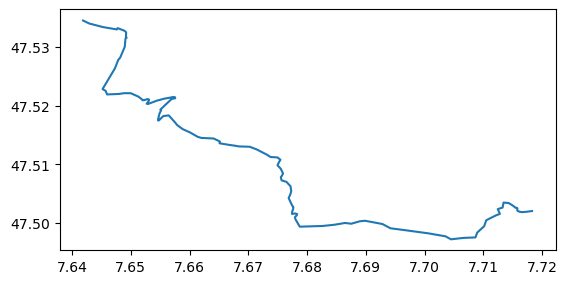

In [28]:
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge

mls     = MultiLineString(gdf_routes.geometry.tolist())
print(mls)
merged  = linemerge(mls)
print(merged)

gdf_merged = gpd.GeoDataFrame(
    {'geometry': [merged]}
)

gdf_merged.plot()

In [36]:
from shapely.geometry import LineString, Point, MultiPoint
from shapely.ops import split
import geopandas as gpd

points = gdf_waypoints.geometry.to_list()

projected = [merged.interpolate(merged.project(pt)) for pt in points]
print(projected)    

mp = MultiPoint(projected)

pieces = split(merged, mp)

segments = list(pieces.geoms)

gdf_points = gpd.GeoDataFrame(
    {'geometry': segments}
)
print(segments)
gdf_points



[<POINT (7.642 47.535)>, <POINT (7.718 47.502)>, <POINT (7.658 47.521)>, <POINT (7.655 47.519)>, <POINT (7.665 47.514)>, <POINT (7.678 47.501)>]
[<LINESTRING (7.642 47.535, 7.643 47.534, 7.645 47.533, 7.648 47.533, 7.648 4...>, <LINESTRING (7.658 47.521, 7.658 47.521, 7.657 47.521, 7.656 47.52, 7.655 47...>, <LINESTRING (7.655 47.519, 7.655 47.519, 7.655 47.519, 7.655 47.518, 7.655 4...>, <LINESTRING (7.665 47.514, 7.667 47.513, 7.668 47.513, 7.668 47.513, 7.67 47...>, <LINESTRING (7.678 47.501, 7.679 47.499, 7.683 47.499, 7.685 47.5, 7.686 47....>]


,geometry
0,"LINESTRING (7.64171 47.53454, 7.64291 47.53396..."
1,"LINESTRING (7.65754 47.52138, 7.65755 47.52123..."
2,"LINESTRING (7.65502 47.51929, 7.65517 47.51919..."
3,"LINESTRING (7.66526 47.51354, 7.66684 47.51328..."
4,"LINESTRING (7.67802 47.50065, 7.67876 47.49937..."


In [38]:
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

gdf_points = gdf_points.set_crs(epsg=4326, allow_override=True)
gdf_lv95 = gdf_points.to_crs(epsg=2056)